# Subscript Random Forest Classificiation on Features (2019-2020)
Random forest classification across a player's achievement history, alone, indicated that customer loyalty is the greatest predictor of whether a subscriber would continue to be engaged in the next subscription period. Consequently, many of the most important features were associated with older content. This iteration of the same random forest only takes into account activity in the past year in order to curate recommendations for current content to at-risk players.

## Import dependencies

In [1]:
import pandas as pd
import os
import subscript.config as cn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics
import numpy as np
from IPython.display import HTML
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

## Read in and prepare data

In [2]:
df = pd.read_csv(os.path.join(cn.clean_dir,'final_feature_stats.csv'), dtype = 'unicode')
player_cols =  ['player','realm','gear_score','last_login',
            'time_since_login','status']
unnamed_cols = [c for c in df.columns if 'Unnamed' in c]
df = df.drop(player_cols, axis = 1)
df = df.drop(unnamed_cols, axis = 1)
dfc = pd.read_csv(os.path.join(cn.clean_dir,
        '6-13_achievement_list.csv'), dtype = 'unicode')
df = df[df.engagement.astype(float) != 1]
df_original = df.copy()
if id in df.columns.names:
    df = df.set_index('id')
print(np.unique(df.engagement))
df.head()

['0.0' '2.0']


,6,7,8,9,10,11,12,13,16,31,...,1419,5386,6124,11056,12173,419,420,1421,1414,11030
0,2016-05-13,2016-05-13,2016-05-13,2016-05-13,2016-05-13,2016-08-22,2016-08-28,2018-01-31,none,none,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-03,2016-07-04,2016-07-04,2016-07-06,2016-07-09,2016-07-13,2016-08-06,2016-08-09,none,2016-08-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-26,2016-07-26,2016-07-26,2016-07-26,2016-07-26,2016-07-26,2016-07-26,2016-07-26,none,2016-10-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-27,2016-07-27,2016-07-27,2016-07-27,2016-07-27,2016-07-27,2016-07-27,2016-07-27,none,2016-10-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2016-08-30,2016-08-30,2016-08-30,2016-08-30,2016-08-30,2016-08-30,2016-08-30,2016-08-30,none,2016-09-21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Convert achievements completed between June 2018 and May 2020 to 1, else 0

In [3]:
df = df_original

In [4]:
xform = [c for c in df.columns.values if 'engagement' \
         not in c and 'id' not in c]
df[xform] = df[xform].replace('none', '0')

In [5]:
for c in xform:
    df[c] = np.where(df[c].str[:4] == '2019', '1', df[c])
    df[c] = np.where(df[c].str[:4] == '2020', '1', df[c])
df

,6,7,8,9,10,11,12,13,16,31,...,1419,5386,6124,11056,12173,419,420,1421,1414,11030
0,2016-05-13,2016-05-13,2016-05-13,2016-05-13,2016-05-13,2016-08-22,2016-08-28,2018-01-31,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-03,2016-07-04,2016-07-04,2016-07-06,2016-07-09,2016-07-13,2016-08-06,2016-08-09,0,2016-08-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-26,2016-07-26,2016-07-26,2016-07-26,2016-07-26,2016-07-26,2016-07-26,2016-07-26,0,2016-10-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-27,2016-07-27,2016-07-27,2016-07-27,2016-07-27,2016-07-27,2016-07-27,2016-07-27,0,2016-10-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2016-08-30,2016-08-30,2016-08-30,2016-08-30,2016-08-30,2016-08-30,2016-08-30,2016-08-30,0,2016-09-21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210917,2008-10-24,2008-10-24,2008-10-24,2008-10-24,2008-10-24,2008-10-24,2008-10-24,2008-12-02,2009-02-06,2008-11-08,...,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
210918,2008-10-28,2008-10-28,2008-10-28,2008-10-28,2008-10-28,2008-10-28,2008-10-28,2009-04-01,0,2009-09-27,...,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
210919,2008-12-30,2008-12-30,2008-12-30,2008-12-30,2008-12-30,2008-12-30,2008-12-30,2009-01-21,0,2015-02-03,...,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
210920,2009-01-07,2009-01-07,2009-01-07,2009-01-07,2009-01-07,2009-01-07,2009-01-07,2010-04-26,0,2009-10-30,...,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN


In [6]:
tmp = df.copy() # Another failsafe copy of the transformed dataset
df[xform] = np.where(df[xform] != '1','0', df[xform])
df

,6,7,8,9,10,11,12,13,16,31,...,1419,5386,6124,11056,12173,419,420,1421,1414,11030
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
210918,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
210919,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
210920,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Intermediate save since the above step took a while

In [7]:
df.to_csv(os.path.join(cn.clean_dir,
    'final_curated_achievements_2019_2020.csv'), index = False)

#### Intermediate step to reload the converted dataframe (if needed)

In [8]:
df = pd.read_csv(os.path.join(cn.clean_dir,
    'final_curated_achievements_2019_2020.csv'), dtype = 'unicode')
#df = df.set_index('id')
df.head()

,6,7,8,9,10,11,12,13,16,31,...,1419,5386,6124,11056,12173,419,420,1421,1414,11030
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Make Training and Test Sets
Dataset is imbalanced, so I'm using stratified shuffle split to ensure the test and train sets have the same proportions of active, at-risk, and lapsed users.

In [9]:
if id in df.columns.names:
    df = df.set_index('id')
try:
    df = df.drop('id', axis = 1)
except:
    pass

df = df[df.engagement.astype(float) != 1].astype(float)
split = StratifiedShuffleSplit(n_splits = 10, test_size = 0.25, 
        random_state = 17)
for train_index, test_index in split.split(df, df.engagement):
    strat_train = df.iloc[train_index][:]
    strat_test = df.iloc[test_index][:]

y_train = strat_train.engagement
X_train = strat_train.drop('engagement', axis = 1)
y_test = strat_test.engagement
X_test = strat_test.drop('engagement', axis = 1)

In [10]:
print(X_train.shape, X_test.shape)

(130954, 4013) (43652, 4013)


(array([35337.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  8315.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

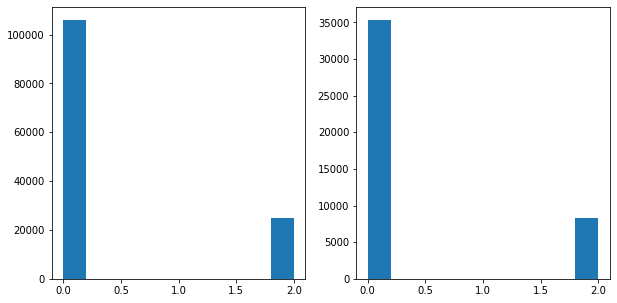

In [11]:
fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].hist(strat_train.engagement)
ax[1].hist(strat_test.engagement)

## Run the Random Forest Classifier for Feature Selection
Tried weapper method, but with 1000 features, even one comparison was not done after 2 hours.
Doing regular feature selection with random forest. 
Weighted due to imbalanced dataset.

In [12]:
class_weight = dict({0:5})
feature_selector = RandomForestClassifier(n_jobs=-1, 
            class_weight = class_weight, bootstrap=True,
            n_estimators=100,
            oob_score=True,random_state=17)
features = feature_selector.fit(np.array(X_train), y_train)


In [13]:
print(X_train.shape, X_test.shape)

(130954, 4013) (43652, 4013)


#### Get the Out-of-Bag score

In [14]:
features.oob_score_

0.9607037585717122

#### Get accuracy score

In [15]:
print(features.score(X_train,y_train))

0.9997938207309437


#### Get Engagement Predictions Based on Achievements

In [16]:
predictions = feature_selector.predict(X_test)
df_pred = pd.DataFrame(X_test)
df_pred['prediction'] = predictions
df_pred['actual'] = y_test
df_pred.to_csv(os.path.join(cn.clean_dir, 'random_forest_features',
        'curated_recommendations_predictions.csv'), index = False)

#### Get Confusion Matrix

In [17]:
met = metrics.classification_report(y_test, predictions, digits=3)
print(met)
cnf_matrix = metrics.confusion_matrix(y_test,predictions)
print(cnf_matrix)

              precision    recall  f1-score   support

         0.0      0.959     0.996     0.977     35337
         2.0      0.978     0.818     0.891      8315

    accuracy                          0.962     43652
   macro avg      0.969     0.907     0.934     43652
weighted avg      0.963     0.962     0.961     43652

[[35186   151]
 [ 1512  6803]]


#### Plot the confusion matrix

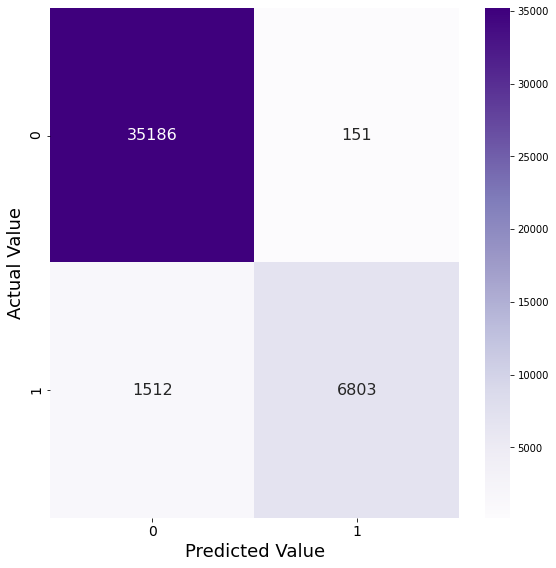

In [18]:
fig2, ax = plt.subplots(figsize = (8,8))
sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = 'Purples', 
            fmt = 'g', annot_kws={"size":16})
ax.set_xlabel ("Predicted Value", fontsize = 18)
ax.set_ylabel ("Actual Value", fontsize = 18)
ax.tick_params (labelsize = 14)
plt.tight_layout()
fig2.savefig(os.path.join(cn.clean_dir, 'random_forest_features',
            'curated_recommendations_cnfmatrix_features.png'), dpi=180)


#### Get Feature Importances

In [40]:
importances = feature_selector.feature_importances_
dfp = pd.DataFrame(importances, index = X_train.columns, 
        columns = ['importance']).sort_values('importance', ascending = False)
dfc = pd.read_csv(os.path.join(cn.clean_dir,
        '6-13_achievement_list.csv'), dtype = 'unicode')
dfp['name'] = ''
dfp['category'] = ''
for index, row in dfp.iterrows():
    dfp.at[index,'name'] = dfc[dfc.achievement_id == str(index)].achievement_name.to_string(index = False)
    dfp.at[index,'category'] = dfc[dfc.achievement_id == str(index)].category_name.to_string(index = False)
dfp.to_csv(os.path.join(cn.clean_dir, 
            'random_forest_features',
            'curated_recommendations_importances.csv'), index = False)
display(HTML(dfp.to_html()))

,importance,name,category
13557,3.642104e-02,Rustbolt Rebellion,Battle for Azeroth
13558,1.003498e-02,Waveblade Ankoan,Battle for Azeroth
13559,7.394899e-03,The Unshackled,Battle for Azeroth
13572,7.120127e-03,The Heart Forge,Heart of Azeroth
13769,6.874234e-03,Power Up,Heart of Azeroth
13770,4.875056e-03,Power Creep,Heart of Azeroth
12956,4.845668e-03,Tortollan Seekers,Battle for Azeroth
12955,4.241948e-03,Champions of Azeroth,Battle for Azeroth
13917,3.217590e-03,WoW's 15th Anniversary,Events
12544,3.090925e-03,Level 120,Character


As expected, the most impactful content involves the latest mini-releases including Visions of N'Zoth, continuous Heart of Azeroth leveling, and Battle for Azeroth expansion features. Secondary features were centered around character improvement, including leveling, gear itemization, professions, and the war effort.

#### Save the Model

In [42]:
# save the model to disk
pickle_name = 'final_feature_model_2_groups.sav'
os.chdir(os.path.join(cn.clean_dir,'random_forest_features' ))
with open(pickle_name, 'wb') as file:
    pickle.dump(features, file)
plt.show()